In [16]:
import sys
import logging
import os
import re
import cv2
import joblib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import tiatoolbox
from IPython.utils import io as IPyIO
from tqdm import tqdm

mpl.rcParams['figure.dpi'] = 300

# adding the project root folder
sys.path.append('../')
from tiatoolbox.models import IOSegmentorConfig, SemanticSegmentor
from tiatoolbox.utils.visualization import overlay_prediction_contours

from misc.utils import cropping_center, recur_find_ext, rmdir
from run_utils.utils import convert_pytorch_checkpoint

TYPE_NAMES = ["lymphocyte", "non-lymphocyte"]
# the fold to use
SPLIT = 'fold_1'
# Random seed for deterministic
SEED = 5
# The number of nuclei within the dataset/predictions.
# For in-house CD3 dataset, we have 2 (+1 for background) types in total.
NUM_TYPES = 3
# The path to the directory containg images.npy etc.
DATA_DIR = '/rds/user/mf774/hpc-work/part_II_project/in-house/training-CD3/data/'
# The path to the pretrained weights
CHECKPOINT_PATH = f'/rds/user/mf774/hpc-work/part_II_project/in-house/training-CD3/models/baseline/{SPLIT}/model/01/net_epoch=50.tar'
# The path to contain output and intermediate processing results
OUT_DIR = '/rds/user/mf774/hpc-work/part_II_project/in-house/training-CD3/validation/'

In [12]:
from natsort import natsorted, ns
import subprocess

imgs = np.load(f'{DATA_DIR}/images.npy', mmap_mode = 'r')
labels = np.load(f'{DATA_DIR}/labels.npy', mmap_mode = 'r')

splits = joblib.load(f'{DATA_DIR}/{SPLIT}_splits.dat')
valid_indices = splits[0]['valid']

other_valid_indices = []

output_file = f'{OUT_DIR}/{SPLIT}/raw/file_map.dat'
output_info = joblib.load(output_file)
for idx in range(len(output_info)):
    image_index = os.path.basename(output_info[idx][0])  # "9997.png"
    match = re.search(r'\d+', image_index)
    if match:
        corresponding_labels_index = int(match.group())  # Convert to integer
        other_valid_indices.append(corresponding_labels_index)
        
print(other_valid_indices)
print(valid_indices)

"""
img_dir = f'{OUT_DIR}/{SPLIT}/imgs'
os.makedirs(img_dir, exist_ok=True)
for idx in valid_indices:
    img = imgs[idx]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(f'{img_dir}/{idx:04d}.png', img)
"""

valid_labels = labels[other_valid_indices]
np.save(f'{OUT_DIR}/{SPLIT}/valid_true.npy', valid_labels)

[0, 2, 4, 7, 8, 9, 12, 13, 14, 18, 19, 20, 21, 22, 23, 25, 30, 32, 34, 36, 37, 39, 41, 44, 50, 51, 53, 55, 56, 60, 63, 64, 65, 68, 72, 73, 76, 78, 80, 82, 83, 87, 90, 91, 95, 97, 100, 105, 108, 112, 113, 116, 118, 123, 130, 131, 137, 139, 142, 144, 146, 147, 149, 151, 158, 160, 162, 164, 165, 169, 170, 171, 172, 174, 175, 177, 179, 181, 182, 184, 187, 190, 191, 193, 195, 196, 198, 199, 201, 202, 204, 205, 206, 208, 209, 212, 213, 214, 217, 218, 219, 220, 230, 231, 232, 235, 236, 241, 244, 246, 250, 251, 253, 254, 255, 256, 258, 259, 261, 262, 263, 266, 267, 269, 270, 275, 276, 278, 283, 284, 286, 288, 290, 291, 292, 295, 296, 299, 304, 307, 308, 309, 310, 311, 312, 313, 317, 318, 320, 321, 322, 323, 325, 326, 329, 331, 334, 337, 340, 341, 342, 343, 344, 346, 349, 354, 356, 357, 363, 366, 369, 370, 373, 374, 376, 379, 380, 382, 383, 385, 388, 389, 390, 391, 394, 396, 397, 398, 401, 403, 404, 405, 406, 411, 412, 413, 415, 419, 423, 430, 431, 439, 440, 442, 443, 444, 445, 447, 453, 455, 4

In [10]:
from net_desc import HoVerNetConic

checkpoint = torch.load(CHECKPOINT_PATH, map_location=torch.device('cpu'))['desc']
checkpoint = convert_pytorch_checkpoint(checkpoint)  # to turn from Multiple GPU Mode to Single GPU Mode
model = HoVerNetConic(num_types=NUM_TYPES)
model.load_state_dict(checkpoint)

# Tile prediction
predictor = SemanticSegmentor(
    model=model,
    num_loader_workers=2,
    batch_size=64,
)

print(predictor.batch_size)

|2025-03-24|18:55:39.645| [WARNING] /tmp/ipykernel_1314884/322566271.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(CHECKPOINT_PATH, map_locatio

|2025-03-24|18:55:42.029| [WARNING] /home/mf774/miniconda3/envs/tiatoolbox/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 805: MPS client failed to connect to the MPS control daemon or the MPS server (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0

|2025-03-24|18:55:42.031| [WARNING] No GPU detected or cuda not installed, torch.compile is only supported on selected NVIDIA GPUs. Speedup numbers may be lower than expected.


64


In [ ]:
# Define the input/output configurations
ioconfig = IOSegmentorConfig(
    input_resolutions=[
        {'units': 'baseline', 'resolution': 1.0},
    ],
    output_resolutions=[
        {'units': 'baseline', 'resolution': 1.0},
        {'units': 'baseline', 'resolution': 1.0},
        {'units': 'baseline', 'resolution': 1.0},
    ],
    save_resolution={'units': 'baseline', 'resolution': 1.0},
    patch_input_shape=[256, 256],
    patch_output_shape=[256, 256],
    stride_shape=[256, 256],
)

logger = logging.getLogger()
logger.disabled = True

infer_img_paths = recur_find_ext(f'{OUT_DIR}/{SPLIT}/imgs/', ext=['.png'])
# rmdir(f'{OUT_DIR}/raw/')


# capture all the printing to avoid cluttering the console
output_file = predictor.predict(
    infer_img_paths,
    masks=None,
    mode='tile',
    #on_gpu=True,
    ioconfig=ioconfig,
    crash_on_exception=True,
    save_dir=f'{OUT_DIR}/{SPLIT}/raw/'
)

In [11]:
def process_segmentation(np_map, hv_map, tp_map):
    # HoVerNet post-proc is coded at 0.25mpp so we resize
    np_map = cv2.resize(np_map, (0, 0), fx=2.0, fy=2.0)
    hv_map = cv2.resize(hv_map, (0, 0), fx=2.0, fy=2.0)
    tp_map = cv2.resize(
                    tp_map, (0, 0), fx=2.0, fy=2.0,
                    interpolation=cv2.INTER_NEAREST)

    inst_map = model._proc_np_hv(np_map[..., None], hv_map)
    inst_dict = model._get_instance_info(inst_map, tp_map)

    # Generating results match with the evaluation protocol
    type_map = np.zeros_like(inst_map)
    inst_type_colours = np.array([
        [v['type']] * 3 for v in inst_dict.values()
    ])
    type_map = overlay_prediction_contours(
        type_map, inst_dict,
        line_thickness=-1,
        inst_colours=inst_type_colours)

    pred_map = np.dstack([inst_map, type_map])
    # The result for evaluation is at 0.5mpp so we scale back
    pred_map = cv2.resize(
                    pred_map, (0, 0), fx=0.5, fy=0.5,
                    interpolation=cv2.INTER_NEAREST)
    return pred_map

In [12]:
def process_composition(pred_map):
    # Only consider the central 224x224 region,
    # as noted in the challenge description paper
    pred_map = cropping_center(pred_map, [512, 512])
    inst_map = pred_map[..., 0]
    type_map = pred_map[..., 1]
    # ignore 0-th index as it is 0 i.e background
    uid_list = np.unique(inst_map)[1:]

    if len(uid_list) < 1:
        type_freqs = np.zeros(NUM_TYPES)
        return type_freqs
    uid_types = [
        np.unique(type_map[inst_map == uid])
        for uid in uid_list
    ]
    type_freqs_ = np.unique(uid_types, return_counts=True)
    # ! not all types exist within the same spatial location
    # ! so we have to create a placeholder and put them there
    type_freqs = np.zeros(NUM_TYPES)
    type_freqs[type_freqs_[0]] = type_freqs_[1]
    return type_freqs

In [ ]:
output_file = f'{OUT_DIR}/{SPLIT}/raw/file_map.dat'
output_info = joblib.load(output_file)

semantic_predictions = []
composition_predictions = []

for input_file, output_root in tqdm(output_info):
    img = cv2.imread(input_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    np_map = np.load(f'{output_root}.raw.0.npy')
    hv_map = np.load(f'{output_root}.raw.1.npy')
    tp_map = np.load(f'{output_root}.raw.2.npy')
    pred_map = process_segmentation(np_map, hv_map, tp_map)
    type_freqs = process_composition(pred_map)
    semantic_predictions.append(pred_map)
    composition_predictions.append(type_freqs)

semantic_predictions = np.array(semantic_predictions)
composition_predictions = np.array(composition_predictions)

np.save(f'{OUT_DIR}/{SPLIT}/valid_pred.npy', semantic_predictions)
df = pd.DataFrame(composition_predictions[:, 1:].astype(np.int32))
df.columns = TYPE_NAMES
df.to_csv(f'{OUT_DIR}/{SPLIT}/valid_pred_cell.csv', index=False)

In [ ]:
# Load up the composition ground truth and
# save the validation portion
df = pd.read_csv(f'{DATA_DIR}/counts.csv')
true_compositions = df.to_numpy()[valid_indices]
df = pd.DataFrame(
    true_compositions.astype(np.int32),
)
df.columns = TYPE_NAMES
df.to_csv(f'{OUT_DIR}/{SPLIT}/valid_true_cell.csv', index=False)

|2025-03-24|21:02:43.834| [WARNING] <>:32: SyntaxWarning: invalid escape sequence '\d'

|2025-03-24|21:02:43.837| [WARNING] <>:32: SyntaxWarning: invalid escape sequence '\d'

|2025-03-24|21:02:43.840| [WARNING] /tmp/ipykernel_2110065/3212337635.py:32: SyntaxWarning: invalid escape sequence '\d'
  """



[['/rds/user/mf774/hpc-work/part_II_project/in-house/training-CD3/validation//fold_1/imgs/0000.png', '/rds/user/mf774/hpc-work/part_II_project/in-house/training-CD3/validation/fold_1/raw/0'], ['/rds/user/mf774/hpc-work/part_II_project/in-house/training-CD3/validation//fold_1/imgs/0002.png', '/rds/user/mf774/hpc-work/part_II_project/in-house/training-CD3/validation/fold_1/raw/1'], ['/rds/user/mf774/hpc-work/part_II_project/in-house/training-CD3/validation//fold_1/imgs/0004.png', '/rds/user/mf774/hpc-work/part_II_project/in-house/training-CD3/validation/fold_1/raw/2'], ['/rds/user/mf774/hpc-work/part_II_project/in-house/training-CD3/validation//fold_1/imgs/0007.png', '/rds/user/mf774/hpc-work/part_II_project/in-house/training-CD3/validation/fold_1/raw/3'], ['/rds/user/mf774/hpc-work/part_II_project/in-house/training-CD3/validation//fold_1/imgs/0008.png', '/rds/user/mf774/hpc-work/part_II_project/in-house/training-CD3/validation/fold_1/raw/4'], ['/rds/user/mf774/hpc-work/part_II_project/i

|2025-03-24|21:03:28.461| [WARNING] /tmp/ipykernel_2110065/3212337635.py:32: SyntaxWarning: invalid escape sequence '\d'
  """



NameError: name 'model' is not defined

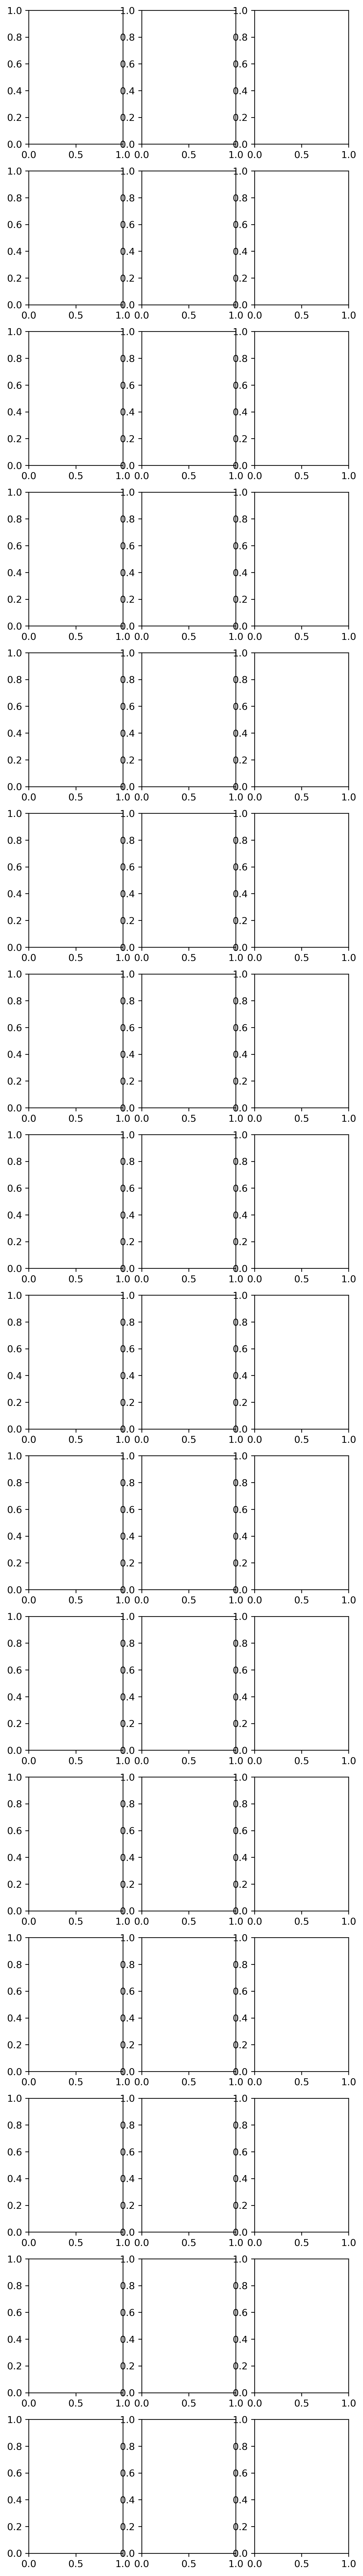

In [ ]:
# semantic_true = np.load('/rds/user/mf774/hpc-work/part_II_project/in-house/training-CD3/data/labels.npy')
semantic_true = np.load(f'{OUT_DIR}/{SPLIT}/valid_true.npy')
semantic_pred = np.load(f'{OUT_DIR}/{SPLIT}/valid_pred.npy')

output_file = f'{OUT_DIR}/{SPLIT}/raw/file_map.dat'
output_info = joblib.load(output_file)
print(output_info)

splits = joblib.load(f'{DATA_DIR}/{SPLIT}_splits.dat')
valid_indices = splits[0]['valid']
print(valid_indices)

np.random.seed(SEED)
selected_indices = np.random.choice(len(valid_indices), 16)  # Unique numbers
print(selected_indices)

PERCEPTIVE_COLORS = [
    (  0,   0,   0),
    (255, 165,   0),
    (  0, 255,   0),
    (255,   0,   0),
    (  0, 255, 255),
    (  0,   0, 255),
    (255, 255,   0),
]

fig, axes = plt.subplots(16, 3, figsize=(6, 48))
for i, idx in enumerate(selected_indices):
    img = cv2.imread(output_info[idx][0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    inst_map = semantic_pred[idx][..., 0]
    type_map = semantic_pred[idx][..., 1]
    pred_inst_dict = model._get_instance_info(inst_map, type_map)

    inst_map = semantic_true[idx][..., 0]
    type_map = semantic_true[idx][..., 1]
    true_inst_dict = model._get_instance_info(inst_map, type_map)

    inst_type_colours = np.array([
        PERCEPTIVE_COLORS[v['type']]
        for v in true_inst_dict.values()
    ])
    overlaid_true = overlay_prediction_contours(
        img, true_inst_dict,
        inst_colours=inst_type_colours,
        line_thickness=1
    )

    inst_type_colours = np.array([
        PERCEPTIVE_COLORS[v['type']]
        for v in pred_inst_dict.values()
    ])
    overlaid_pred = overlay_prediction_contours(
        img, pred_inst_dict,
        inst_colours=inst_type_colours,
        line_thickness=1
    )

    axes[i, 0].imshow(img)
    axes[i, 0].axis("off")
    axes[i, 0].set_title(f"Input")
    axes[i, 1].imshow(overlaid_true)
    axes[i, 1].axis("off")
    axes[i, 1].set_title(f"Ground Truth")
    axes[i, 2].imshow(overlaid_pred)
    axes[i, 2].axis("off")
    axes[i, 2].set_title(f"Prediction")
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/{SPLIT}/example-patches/example-patches.png")
plt.show()